In [1]:
import pandas as pd          
import numpy as np          # For mathematical calculations 
import matplotlib.pyplot as plt  # For plotting graphs 
from datetime import datetime    # To access datetime 
from pandas import Series        # To work on series 
%matplotlib inline 
import warnings   
import seaborn as sns
import itertools
import math
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.linear_model import LinearRegression
from math import sqrt 
from matplotlib import pyplot
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

In [2]:
data=pd.read_csv("data.csv") 
data_original=data.copy()

#### Convert date column into date format

In [3]:
data['calendar_date'] = pd.to_datetime(data.calendar_date,format='%m/%d/%Y') 
data.index = data['calendar_date']
data.sort_index(inplace=True)

### There are some negative volume, revenue
+ It could be due to goods return
+ It might be data error, some numbers are mistakely with negative sign

Assumption: I consider it as an error. Therefore, I would change the sign of negative numbers

Before that let's look at number of rows with negative values corresponding each column

In [4]:
data[data<0].count()

product_id          0
calendar_date    1340
volume_sold         1
revenue             1
cost                1
vdm1                1
vwm1                6
vmm1                6
vmm2                0
vmm13               0
rdm1                1
rwm1                6
rmm1                5
rmm2                0
rmm13               0
cdm1                1
cwm1                6
cmm1                6
cmm2                0
cmm13               0
mpdm1               0
mpwm1               0
mpmm1               0
mpmm2               0
mpmm13              0
stock_level         2
retail_price        0
woy                 0
dtype: int64

In [5]:
data['volume_sold']=data['volume_sold'].abs()
data['revenue']=data['revenue'].abs()
data['cost']=data['cost'].abs()
data['vdm1']=data['vdm1'].abs()
data['vwm1']=data['vwm1'].abs()
data['vmm1']=data['vmm1'].abs()
data['rdm1']=data['rdm1'].abs()
data['rwm1']=data['rwm1'].abs()
data['rmm1']=data['rmm1'].abs()
data['cdm1']=data['cdm1'].abs()
data['cwm1']=data['cwm1'].abs()
data['cmm1']=data['cmm1'].abs()
data['stock_level']=data['stock_level'].abs()

# Helper Functions

In [6]:
def randomized_search_CV(algorithm,tuned_parameters,train_x,train_y,iteration,verbose_int,jobs_int=1):
    """
    This function performs randomized search on set of features, perform cross validation and fit the data in the specified model.
    It returns best set of features.
    
    Args:
        algorithm: Model to fit
        tuned_parameters: Set of possible parameters to choose
        train_x: training data (features) 
        train_y: training label
        iteration: number of itearation to choose random set of parameters
        
    Returns:
        set of best parameters
    
    """
    
    score = 'neg_mean_squared_error'

    print("# Tuning hyper-parameters for mean_squared_error" )
    print()
     
    clf = RandomizedSearchCV(algorithm, param_distributions=tuned_parameters, cv=5,n_iter = iteration, scoring='neg_mean_squared_error',verbose=verbose_int,n_jobs=jobs_int)
    clf.fit(train_x,train_y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    #print("Grid scores on development set:")
    #print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    #for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        #print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
        
    return clf.best_params_

In [7]:
def weekend(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0 

In [8]:
# Based on assumption that we have mean_retail_price (retail_price on next 28 days)
def price_diff_retail_price_with_max_price_in_previous_periods(df):
    
    df['Retail_price_diff_max_price_in_last_2month']=df['retail_price'] -df['mpmm2']/28
    df['Retail_price_diff_max_price_in_last_year_13month']=df['retail_price'] -df['mpmm13']/28
    
    return df

In [9]:
def fit_features_scaler(df_train):
    
    scaler = StandardScaler()
    scaler.fit(df_train.drop('volume_sold', axis=1))
        
    return scaler
    
def transform_features(df, scaler):
   
    df_features = df.drop('volume_sold', axis=1)
    df_scaled = pd.DataFrame(scaler.transform(df_features), columns=df_features.columns)
       
    
    return df_scaled

# Features

#### Time Features

In [10]:
data['month']=data.calendar_date.dt.month 
data['day']=data.calendar_date.dt.day

In [11]:

temp2 = data['calendar_date'].apply(weekend) 
data['weekend']=temp2

### Difference in current retail price with previous maximum prices

In [12]:
data=price_diff_retail_price_with_max_price_in_previous_periods(data)

#### Feature list

In [13]:
features_col=list(set(data.columns.tolist())-set(["product_id","calendar_date","revenue","cost","stock_level","woy"]))

In [14]:
columns_to_encode = ['month','day','weekend']
columns_to_scale = list(set(features_col)-set(columns_to_encode))

# Modeling

### Linear Regression

In [15]:
tuned_parameters = {'fit_intercept':[True,False], 
                    'normalize':[True,False], 
                    'copy_X':[True, False]}


______________
13701
# Tuning hyper-parameters for mean_squared_error



/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'normalize': False, 'fit_intercept': True, 'copy_X': True}



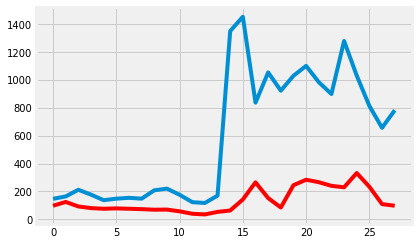

____________________________________________________________________________________________________ 

Sum of Original Sales for next 28 days:  16510.0
Sum of Predicted Sales for next 28 days:  [3762.38818593]
The difference between model original and predictions values of the is [12747.61181407]
____________________________________________________________________________________________________ 

The RMSE of the Linear Regression is 606.6912748547433
____________________________________________________________________________________________________ 

The MSE of the Linear Regression is 368074.3029848736
____________________________________________________________________________________________________ 

The MAE of the Linear Regression is 455.27185050256503
____________________________________________________________________________________________________ 

______________
26104
# Tuning hyper-parameters for mean_squared_error



/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'normalize': False, 'fit_intercept': True, 'copy_X': True}



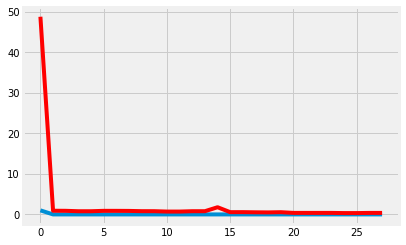

____________________________________________________________________________________________________ 

Sum of Original Sales for next 28 days:  1.0
Sum of Predicted Sales for next 28 days:  [66.66283707]
The difference between model original and predictions values of the is [-65.66283707]
____________________________________________________________________________________________________ 

The RMSE of the Linear Regression is 9.052360663213983
____________________________________________________________________________________________________ 

The MSE of the Linear Regression is 81.9452335769039
____________________________________________________________________________________________________ 

The MAE of the Linear Regression is 2.345101324084166
____________________________________________________________________________________________________ 

______________
158737
# Tuning hyper-parameters for mean_squared_error

Best parameters set found on development set:

{'normalize': Tru

/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


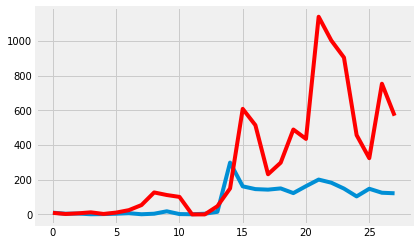

____________________________________________________________________________________________________ 

Sum of Original Sales for next 28 days:  2296.0
Sum of Predicted Sales for next 28 days:  [8393.14359625]
The difference between model original and predictions values of the is [-6097.14359625]
____________________________________________________________________________________________________ 

The RMSE of the Linear Regression is 354.29752141366373
____________________________________________________________________________________________________ 

The MSE of the Linear Regression is 125526.7336798655
____________________________________________________________________________________________________ 

The MAE of the Linear Regression is 228.92710504919114
____________________________________________________________________________________________________ 

______________
158105
# Tuning hyper-parameters for mean_squared_error

Best parameters set found on development set:

{'norma

/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


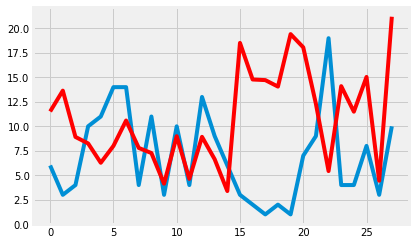

____________________________________________________________________________________________________ 

Sum of Original Sales for next 28 days:  195.0
Sum of Predicted Sales for next 28 days:  [302.5000394]
The difference between model original and predictions values of the is [-107.5000394]
____________________________________________________________________________________________________ 

The RMSE of the Linear Regression is 8.51559732077104
____________________________________________________________________________________________________ 

The MSE of the Linear Regression is 72.51539772952292
____________________________________________________________________________________________________ 

The MAE of the Linear Regression is 6.928788270117425
____________________________________________________________________________________________________ 



In [16]:
data_model=data.dropna()
products=list(data['product_id'].unique())
for i in range(len(list(products))):
    print("______________")
    print(products[i])

    
    data_model_df=data_model[data_model['product_id']==products[i]]
    for j in range(len(products)):
        if i!=j:
            data_model_df[str(products[j])+'_comp1_price']=data[data['product_id']==products[i]]['retail_price']
            data_model_df['Item_comp_price_diff_'+str(products[j])]=data[data['product_id']==products[i]]['retail_price'] - data_model_df[str(products[j])+'_comp1_price']
    features_col=list(set(data_model_df.columns.tolist())-set(["product_id","calendar_date","revenue","cost","stock_level","woy",]))
    
    df_train=data_model_df[data_model_df["calendar_date"]<="2017-10-31"][features_col]
    df_test=data_model_df[data_model_df["calendar_date"]>"2017-10-31"][features_col]
    df_test=df_test.head(28)
    
    # scale features
    
    feature_scaler = fit_features_scaler(df_train)
    feature_train_scaled = transform_features(df_train, feature_scaler)
    feature_test_scaled = transform_features(df_test, feature_scaler)

    df_test_cur=df_test
    
    history = [x for x in df_train['volume_sold']]
    history=np.array(history)
    history = history.astype('float32')
    history=list(history)
    
    
    df_test = [x for x in df_test['volume_sold']]
    df_test=np.array(df_test)
    df_test = df_test.astype('float32')
    
    params=randomized_search_CV(LinearRegression(),tuned_parameters,feature_train_scaled,np.log(df_train['volume_sold']+1),10,0,1)
    
    predictions = list()
    
    for k in range(len(feature_test_scaled)):
        feature_test_scaled_cur=feature_test_scaled.iloc[k]
        feature_test_scaled_cur=feature_test_scaled_cur.to_frame().T
        model = LinearRegression(params)
        
        history=[1 if x==0 else x for x in history]
        model.fit(feature_train_scaled,np.log(history))
        
        Prediction=model.predict(feature_test_scaled_cur)
        yhat = np.exp(Prediction)
        predictions.append(yhat)
        feature_train_scaled=feature_train_scaled.append(feature_test_scaled_cur)
        
        history.append(yhat)
        
    # plot
    plt.plot(df_test,label="Original")
    plt.plot(predictions, color='red',label="Predictions")
    plt.show()  
        
       
    print("__"*50,"\n")
    print("Sum of Original Sales for next 28 days: ",str(sum(df_test)))
    print("Sum of Predicted Sales for next 28 days: ",str(sum(predictions)))
    print('The difference between model original and predictions values of the is',sum(df_test) - sum(predictions))
   
    
    print("__"*50,"\n")
    print('The RMSE of the Linear Regression is',sqrt(mean_squared_error(df_test,predictions)))
    print("__"*50,"\n")
    
    print('The MSE of the Linear Regression is',mean_squared_error(df_test,predictions))
   
    print("__"*50,"\n")
    print('The MAE of the Linear Regression is',mean_absolute_error(df_test,predictions))

    
    print("__"*50,"\n")
    

#### Support Vector

In [17]:
tuned_parameters = {'kernel': ['rbf','poly'], 
                    'gamma': [1e-3, 1e-4],
                     'C': [1,10,50,100],
                    'degree':[3,4,6]}
                   

______________
13701
# Tuning hyper-parameters for mean_squared_error



/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'kernel': 'rbf', 'gamma': 0.001, 'degree': 4, 'C': 10}



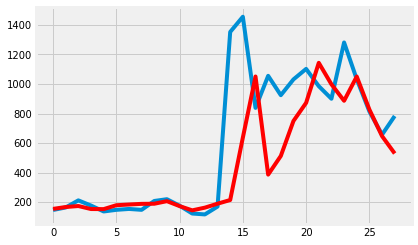

____________________________________________________________________________________________________ 

Sum of Original Sales for next 28 days:  16510.0
Sum of Predicted Sales for next 28 days:  [12922.83630481]
The difference between model original and predictions values of the is [3587.16369519]
____________________________________________________________________________________________________ 

The RMSE of the Support Vectors Regression is 328.4597384979282
____________________________________________________________________________________________________ 

The MSE of the Support Vectors is 107885.79981412736
____________________________________________________________________________________________________ 

The MAE of the Support Vectors is 179.11171277346435
____________________________________________________________________________________________________ 

______________
26104
# Tuning hyper-parameters for mean_squared_error



/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'kernel': 'rbf', 'gamma': 0.001, 'degree': 4, 'C': 10}



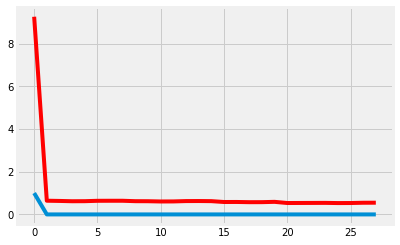

____________________________________________________________________________________________________ 

Sum of Original Sales for next 28 days:  1.0
Sum of Predicted Sales for next 28 days:  [25.22729394]
The difference between model original and predictions values of the is [-24.22729394]
____________________________________________________________________________________________________ 

The RMSE of the Support Vectors Regression is 1.666108032986196
____________________________________________________________________________________________________ 

The MSE of the Support Vectors is 2.7759159775811306
____________________________________________________________________________________________________ 

The MAE of the Support Vectors is 0.8652604978733234
____________________________________________________________________________________________________ 

______________
158737
# Tuning hyper-parameters for mean_squared_error



/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'kernel': 'rbf', 'gamma': 0.001, 'degree': 3, 'C': 50}



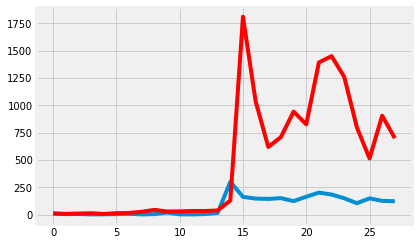

____________________________________________________________________________________________________ 

Sum of Original Sales for next 28 days:  2296.0
Sum of Predicted Sales for next 28 days:  [13393.04996097]
The difference between model original and predictions values of the is [-11097.04996097]
____________________________________________________________________________________________________ 

The RMSE of the Support Vectors Regression is 627.560890342356
____________________________________________________________________________________________________ 

The MSE of the Support Vectors is 393832.67108729045
____________________________________________________________________________________________________ 

The MAE of the Support Vectors is 408.50564855673434
____________________________________________________________________________________________________ 

______________
158105
# Tuning hyper-parameters for mean_squared_error



/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'kernel': 'rbf', 'gamma': 0.0001, 'degree': 6, 'C': 1}



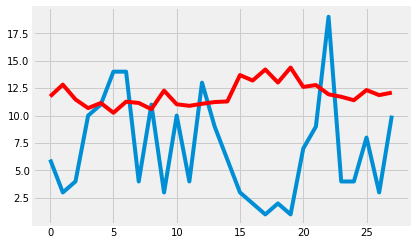

____________________________________________________________________________________________________ 

Sum of Original Sales for next 28 days:  195.0
Sum of Predicted Sales for next 28 days:  [334.07459188]
The difference between model original and predictions values of the is [-139.07459188]
____________________________________________________________________________________________________ 

The RMSE of the Support Vectors Regression is 7.208276759763774
____________________________________________________________________________________________________ 

The MSE of the Support Vectors is 51.95925384535054
____________________________________________________________________________________________________ 

The MAE of the Support Vectors is 6.1019397883896005
____________________________________________________________________________________________________ 



In [18]:
from matplotlib import pyplot
data_model=data.dropna()
products=list(data['product_id'].unique())
for i in range(len(list(products))):
    print("______________")
    print(products[i])

    
    data_model_df=data_model[data_model['product_id']==products[i]]
    for j in range(len(products)):
        if i!=j:
            data_model_df[str(products[j])+'_comp1_price']=data[data['product_id']==products[i]]['retail_price']
            data_model_df['Item_comp_price_diff_'+str(products[j])]=data[data['product_id']==products[i]]['retail_price'] - data_model_df[str(products[j])+'_comp1_price']
    features_col=list(set(data_model_df.columns.tolist())-set(["product_id","calendar_date","revenue","cost","stock_level","woy",]))
    
    df_train=data_model_df[data_model_df["calendar_date"]<="2017-10-31"][features_col]
    df_test=data_model_df[data_model_df["calendar_date"]>"2017-10-31"][features_col]
    df_test=df_test.head(28)
    
    # scale features
    
    feature_scaler = fit_features_scaler(df_train)
    feature_train_scaled = transform_features(df_train, feature_scaler)
    feature_test_scaled = transform_features(df_test, feature_scaler)

    df_test_cur=df_test
    
    history = [x for x in df_train['volume_sold']]
    history=np.array(history)
    history = history.astype('float32')
    history=list(history)
    
    
    df_test = [x for x in df_test['volume_sold']]
    df_test=np.array(df_test)
    df_test = df_test.astype('float32')
    
    params=randomized_search_CV(SVR(),tuned_parameters,feature_train_scaled,np.log(df_train['volume_sold']+1),10,0,1)
    
    predictions = list()
    
    for k in range(len(feature_test_scaled)):
        feature_test_scaled_cur=feature_test_scaled.iloc[k]
        feature_test_scaled_cur=feature_test_scaled_cur.to_frame().T
        model = SVR(**params)
        
        history=[1 if x==0 else x for x in history]
        model.fit(feature_train_scaled,np.log(history))
        
        Prediction=model.predict(feature_test_scaled_cur)
        yhat = np.exp(Prediction)
        predictions.append(yhat)
        feature_train_scaled=feature_train_scaled.append(feature_test_scaled_cur)
        
        history.append(yhat)
        
    # plot
    plt.plot(df_test,label="Original")
    plt.plot(predictions, color='red',label="Predictions")
    plt.show()  
        
       
    print("__"*50,"\n")
    print("Sum of Original Sales for next 28 days: ",str(sum(df_test)))
    print("Sum of Predicted Sales for next 28 days: ",str(sum(predictions)))
    print('The difference between model original and predictions values of the is',sum(df_test) - sum(predictions))
 
    
    
    print("__"*50,"\n")
    print('The RMSE of the Support Vectors Regression is',sqrt(mean_squared_error(df_test,predictions)))
    print("__"*50,"\n")
    
    print('The MSE of the Support Vectors is',mean_squared_error(df_test,predictions))
   
    print("__"*50,"\n")
    print('The MAE of the Support Vectors is',mean_absolute_error(df_test,predictions))

    
    print("__"*50,"\n")
    

### Random Forest

In [19]:
# A parameter grid for RandomForestRegressor
tuned_parameters = {
        'n_estimators': [100,150,200,300,400],
        'bootstrap': [True, False],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'max_depth': [7,8,9,10]
        }

______________
13701
# Tuning hyper-parameters for mean_squared_error



/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': True}



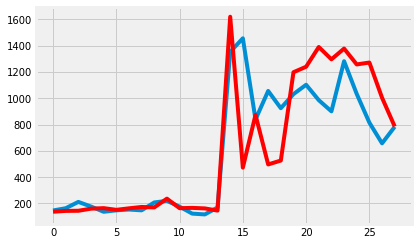

____________________________________________________________________________________________________ 

Sum of Original Sales for next 28 days:  16510.0
Sum of Predicted Sales for next 28 days:  [17087.56271107]
The difference between model original and predictions values of the is [-577.56271107]
____________________________________________________________________________________________________ 

____________________________________________________________________________________________________ 

The RMSE of the RF Regression is 285.04409268086215
____________________________________________________________________________________________________ 

The MSE of the RF is 81250.13477225591
____________________________________________________________________________________________________ 

The MAE of the RF is 172.4397177306242
____________________________________________________________________________________________________ 

______________
26104
# Tuning hyper-parameters for mean_s

/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': True}



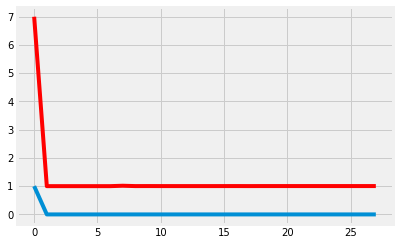

____________________________________________________________________________________________________ 

Sum of Original Sales for next 28 days:  1.0
Sum of Predicted Sales for next 28 days:  [34.05904217]
The difference between model original and predictions values of the is [-33.05904217]
____________________________________________________________________________________________________ 

____________________________________________________________________________________________________ 

The RMSE of the RF Regression is 1.500512477853722
____________________________________________________________________________________________________ 

The MSE of the RF is 2.2515376961947164
____________________________________________________________________________________________________ 

The MAE of the RF is 1.1806800775445496
____________________________________________________________________________________________________ 

______________
158737
# Tuning hyper-parameters for mean_squared

/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 8, 'bootstrap': True}



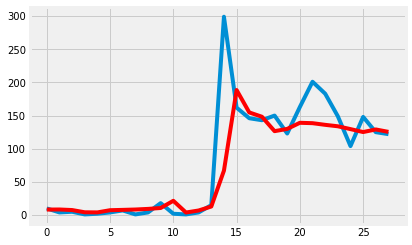

____________________________________________________________________________________________________ 

Sum of Original Sales for next 28 days:  2296.0
Sum of Predicted Sales for next 28 days:  [1993.29683346]
The difference between model original and predictions values of the is [302.70316654]
____________________________________________________________________________________________________ 

____________________________________________________________________________________________________ 

The RMSE of the RF Regression is 47.777333341760595
____________________________________________________________________________________________________ 

The MSE of the RF is 2282.6735812497086
____________________________________________________________________________________________________ 

The MAE of the RF is 20.45728774809145
____________________________________________________________________________________________________ 

______________
158105
# Tuning hyper-parameters for mean_sq

/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': True}



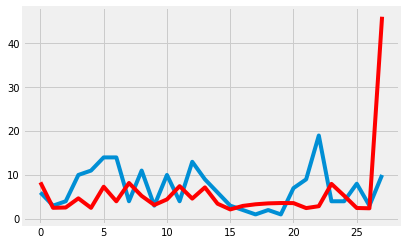

____________________________________________________________________________________________________ 

Sum of Original Sales for next 28 days:  195.0
Sum of Predicted Sales for next 28 days:  [164.07136785]
The difference between model original and predictions values of the is [30.92863215]
____________________________________________________________________________________________________ 

____________________________________________________________________________________________________ 

The RMSE of the RF Regression is 8.676992708122471
____________________________________________________________________________________________________ 

The MSE of the RF is 75.29020245681053
____________________________________________________________________________________________________ 

The MAE of the RF is 5.3016323714983
____________________________________________________________________________________________________ 



In [20]:
from matplotlib import pyplot
data_model=data.dropna()
products=list(data['product_id'].unique())
for i in range(len(list(products))):
    print("______________")
    print(products[i])

    
    data_model_df=data_model[data_model['product_id']==products[i]]
    for j in range(len(products)):
        if i!=j:
            data_model_df[str(products[j])+'_comp1_price']=data[data['product_id']==products[i]]['retail_price']
            data_model_df['Item_comp_price_diff_'+str(products[j])]=data[data['product_id']==products[i]]['retail_price'] - data_model_df[str(products[j])+'_comp1_price']
    features_col=list(set(data_model_df.columns.tolist())-set(["product_id","calendar_date","revenue","cost","stock_level","woy",]))
    
    df_train=data_model_df[data_model_df["calendar_date"]<="2017-10-31"][features_col]
    df_test=data_model_df[data_model_df["calendar_date"]>"2017-10-31"][features_col]
    df_test=df_test.head(28)
    
    # scale features
    
    feature_scaler = fit_features_scaler(df_train)
    feature_train_scaled = transform_features(df_train, feature_scaler)
    feature_test_scaled = transform_features(df_test, feature_scaler)

    df_test_cur=df_test
    
    history = [x for x in df_train['volume_sold']]
    history=np.array(history)
    history = history.astype('float32')
    history=list(history)
    
    
    df_test = [x for x in df_test['volume_sold']]
    df_test=np.array(df_test)
    df_test = df_test.astype('float32')
    
    params=randomized_search_CV(RandomForestRegressor(),tuned_parameters,feature_train_scaled,np.log(df_train['volume_sold']+1),10,0,1)
    
    predictions = list()
    
    for k in range(len(feature_test_scaled)):
        feature_test_scaled_cur=feature_test_scaled.iloc[k]
        feature_test_scaled_cur=feature_test_scaled_cur.to_frame().T
        model = RandomForestRegressor(**params)
        
        history=[1 if x==0 else x for x in history]
        model.fit(feature_train_scaled,np.log(history))
        
        Prediction=model.predict(feature_test_scaled_cur)
        yhat = np.exp(Prediction)
        predictions.append(yhat)
        feature_train_scaled=feature_train_scaled.append(feature_test_scaled_cur)
        
        history.append(yhat)
        
    # plot
    plt.plot(df_test,label="Original")
    plt.plot(predictions, color='red',label="Predictions")
    plt.show()  
        
       
    print("__"*50,"\n")
    print("Sum of Original Sales for next 28 days: ",str(sum(df_test)))
    print("Sum of Predicted Sales for next 28 days: ",str(sum(predictions)))
    print('The difference between model original and predictions values of the is',sum(df_test) - sum(predictions))

    
    print("__"*50,"\n") 
    
    
    print("__"*50,"\n")
    print('The RMSE of the RF Regression is',sqrt(mean_squared_error(df_test,predictions)))
    print("__"*50,"\n")
    
    print('The MSE of the RF is',mean_squared_error(df_test,predictions))
   
    print("__"*50,"\n")
    print('The MAE of the RF is',mean_absolute_error(df_test,predictions))

    
    print("__"*50,"\n")
    

### XGBoost

In [21]:
# A parameter grid for XGBoost
tuned_parameters = {
        'n_estimators': [10,50,100,150,200,300],
        'min_child_weight': [3,4],
        'gamma':  [0],
        'subsample': [ 0.7, 0.8],
        'colsample_bytree': [ 0.7, 0.8],
        'max_depth': [7,8],
        'learning_rate' : [ 0.05, 0.1]
        }

______________
13701
# Tuning hyper-parameters for mean_squared_error



/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'subsample': 0.8, 'n_estimators': 150, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}



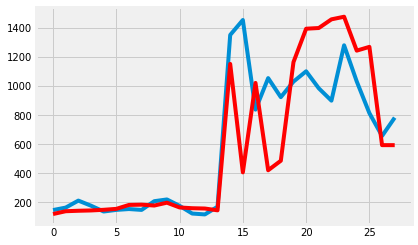

________________________________________________________________________________ 

Sum of Original Sales for next 28 days:  16510.0
Sum of Predicted Sales for next 28 days:  [16305.937]
The difference between model original and predictions values of the is [204.06348]
________________________________________________________________________________ 

The RMSE of the XGBoost Regression is 310.6228998922971
________________________________________________________________________________ 

The MSE of the XGBoost is 96486.586
________________________________________________________________________________ 

The MAE of the XGBoost is 193.76852
________________________________________________________________________________ 

______________
26104
# Tuning hyper-parameters for mean_squared_error



/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'subsample': 0.8, 'n_estimators': 50, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.7}



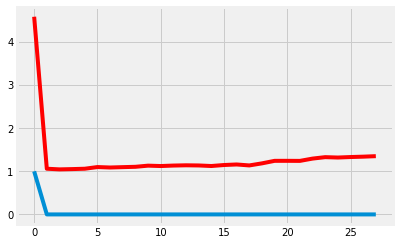

________________________________________________________________________________ 

Sum of Original Sales for next 28 days:  1.0
Sum of Predicted Sales for next 28 days:  [36.298325]
The difference between model original and predictions values of the is [-35.298325]
________________________________________________________________________________ 

The RMSE of the XGBoost Regression is 1.3411237202521888
________________________________________________________________________________ 

The MSE of the XGBoost is 1.7986128
________________________________________________________________________________ 

The MAE of the XGBoost is 1.2606543
________________________________________________________________________________ 

______________
158737
# Tuning hyper-parameters for mean_squared_error



/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'subsample': 0.7, 'n_estimators': 100, 'min_child_weight': 4, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.7}



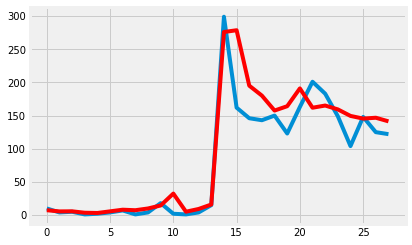

________________________________________________________________________________ 

Sum of Original Sales for next 28 days:  2296.0
Sum of Predicted Sales for next 28 days:  [2645.2656]
The difference between model original and predictions values of the is [-349.26562]
________________________________________________________________________________ 

The RMSE of the XGBoost Regression is 30.713128538923506
________________________________________________________________________________ 

The MSE of the XGBoost is 943.29626
________________________________________________________________________________ 

The MAE of the XGBoost is 18.811571
________________________________________________________________________________ 

______________
158105
# Tuning hyper-parameters for mean_squared_error



/home/bhbhan/.conda/envs/newron_clone/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'subsample': 0.8, 'n_estimators': 150, 'min_child_weight': 4, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.7}



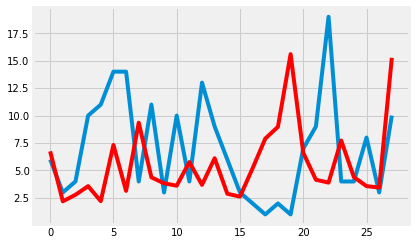

________________________________________________________________________________ 

Sum of Original Sales for next 28 days:  195.0
Sum of Predicted Sales for next 28 days:  [156.98453]
The difference between model original and predictions values of the is [38.015472]
________________________________________________________________________________ 

The RMSE of the XGBoost Regression is 6.3757557140540575
________________________________________________________________________________ 

The MSE of the XGBoost is 40.65026
________________________________________________________________________________ 

The MAE of the XGBoost is 4.943273
________________________________________________________________________________ 



In [22]:
data_model=data.dropna()
products=list(data['product_id'].unique())
for i in range(len(list(products))):
    print("______________")
    print(products[i])

    
    data_model_df=data_model[data_model['product_id']==products[i]]
    for j in range(len(products)):
        if i!=j:
            data_model_df[str(products[j])+'_comp1_price']=data[data['product_id']==products[i]]['retail_price']
            data_model_df['Item_comp_price_diff_'+str(products[j])]=data[data['product_id']==products[i]]['retail_price'] - data_model_df[str(products[j])+'_comp1_price']
    features_col=list(set(data_model_df.columns.tolist())-set(["product_id","calendar_date","revenue","cost","stock_level","woy",]))
    
    df_train=data_model_df[data_model_df["calendar_date"]<="2017-10-31"][features_col]
    df_test=data_model_df[data_model_df["calendar_date"]>"2017-10-31"][features_col]
    df_test=df_test.head(28)
    
    # scale features
    
    feature_scaler = fit_features_scaler(df_train)
    feature_train_scaled = transform_features(df_train, feature_scaler)
    feature_test_scaled = transform_features(df_test, feature_scaler)

    df_test_cur=df_test
    
    history = [x for x in df_train['volume_sold']]
    history=np.array(history)
    history = history.astype('float32')
    history=list(history)
    
    
    df_test = [x for x in df_test['volume_sold']]
    df_test=np.array(df_test)
    df_test = df_test.astype('float32')
    
    params=randomized_search_CV(XGBRegressor(),tuned_parameters,feature_train_scaled,np.log(df_train['volume_sold']+1),10,0,1)
    
    predictions = list()
    
    for k in range(len(feature_test_scaled)):
        feature_test_scaled_cur=feature_test_scaled.iloc[k]
        feature_test_scaled_cur=feature_test_scaled_cur.to_frame().T
        model = XGBRegressor(**params)
        
        history=[1 if x==0 else x for x in history]
        model.fit(feature_train_scaled,np.log(history))
        
        Prediction=model.predict(feature_test_scaled_cur)
        yhat = np.exp(Prediction)
        predictions.append(yhat)
        feature_train_scaled=feature_train_scaled.append(feature_test_scaled_cur)
        
        history.append(yhat)
        
    # plot
    plt.plot(df_test,label="Original")
    plt.plot(predictions, color='red',label='Predictions')
    plt.show()  
        
       
    
    print("__"*40,"\n")
    print("Sum of Original Sales for next 28 days: ",str(sum(df_test)))
    print("Sum of Predicted Sales for next 28 days: ",str(sum(predictions)))
    print('The difference between model original and predictions values of the is',sum(df_test) - sum(predictions))

    
    print("__"*40,"\n")
    
    print('The RMSE of the XGBoost Regression is',sqrt(mean_squared_error(df_test,predictions)))
    print("__"*40,"\n")
    
    print('The MSE of the XGBoost is',mean_squared_error(df_test,predictions))
   
    print("__"*40,"\n")
    print('The MAE of the XGBoost is',mean_absolute_error(df_test,predictions))

    
    print("__"*40,"\n")
    